# Detectron2

In [1]:
%pip install roboflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("aerial-person-detection").project("aerial-person-detection")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Aerial-Person-Detection-3 in coco:: 100%|██████████| 6994/6994 [03:46<00:00, 30.94it/s]


In [1]:
%pip install 'git+https://github.com/facebookresearch/detectron2.git'

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-0u6yyn03
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-0u6yyn03
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import cv2
import json
from PIL import Image
import torch
from matplotlib import pyplot as plt
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer
print(detectron2.__version__)

0.6


# Фильтрация аннотаций для одного класса

In [38]:
for i in ['train', 'valid']:
    # Загрузка JSON-файла с аннотациями
    with open(f"/home/jupyter/datasphere/project/Aerial-Person-Detection-3/{i}/_annotations.coco.json", "r") as f:
        data = json.load(f)
    # Фильтрация аннотаций: оставляем только те, где category_id соответствует person
    person_category_id = 5  # Убедитесь, что это правильный ID для класса "person"
    filtered_annotations = [ann for ann in data["annotations"] if ann["category_id"] == person_category_id]

    # Обновление данных
    data["annotations"] = filtered_annotations
    data["categories"] = [{'id': 5, 'name': 'person', 'supercategory': 'people'}]
    
    # Сохранение отфильтрованного JSON-файла
    with open(f"/home/jupyter/datasphere/project/Aerial-Person-Detection-3/{i}/_annotations_filtered.coco.json", "w") as f:
        json.dump(data, f)

## Обучение Detectron2

In [39]:
register_coco_instances("my_dataset_train", 
                        {}, 
                        "/home/jupyter/datasphere/project/Aerial-Person-Detection-3/train/_annotations_filtered.coco.json", 
                        "/home/jupyter/datasphere/project/Aerial-Person-Detection-3/train")
register_coco_instances("my_dataset_val", 
                        {}, 
                        "/home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/_annotations_filtered.coco.json", 
                        "/home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/")
                        

In [40]:
MetadataCatalog.get("my_dataset_train").set(thing_classes=["person"])
MetadataCatalog.get("my_dataset_val").set(thing_classes=["person"])

namespace(name='my_dataset_val',
          json_file='/home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/_annotations_filtered.coco.json',
          image_root='/home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/',
          evaluator_type='coco',
          thing_classes=['person'],
          thing_dataset_id_to_contiguous_id={5: 0})

In [49]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Предобученные веса
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "/home/jupyter/datasphere/project/output"

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/16 15:10:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[03/16 15:10:41 d2.engine.train_loop]: Starting training from iteration 0
[03/16 15:11:07 d2.utils.events]:  eta: 0:21:35  iter: 19  total_loss: 2.257  loss_cls: 0.7692  loss_box_reg: 0.2051  loss_rpn_cls: 0.8115  loss_rpn_loc: 0.4613    time: 1.3087  last_time: 1.3360  data_time: 0.0235  last_data_time: 0.0100   lr: 4.9953e-06  max_mem: 11079M
[03/16 15:11:33 d2.utils.events]:  eta: 0:21:16  iter: 39  total_loss: 1.793  loss_cls: 0.7089  loss_box_reg: 0.2466  loss_rpn_cls: 0.4294  loss_rpn_loc: 0.3901    time: 1.3129  last_time: 1.2054  data_time: 0.0092  last_data_time: 0.0084   lr: 9.9902e-06  max_mem: 11079M
[03/16 15:11:59 d2.utils.events]:  eta: 0:20:50  iter: 59  total_loss: 1.443  loss_cls: 0.6113  loss_box_reg: 0.2233  loss_rpn_cls: 0.2373  loss_rpn_loc: 0.3163    time: 1.2995  last_time: 1.3405  data_time: 0.0086  last_data_time: 0.0090   lr: 1.4985e-05  max_mem: 11079M
[03/16 15:12:25 d2.utils.events]:  eta: 0:20:24  iter: 79  total_loss: 1.405  loss_cls: 0.4992  loss_box_re

## Проверка метрики качества модели

### С помощью встроенных методов 

Создадим предиктор для только что обученной модели

In [51]:
predictor_cfg = cfg.clone()
predictor_cfg.MODEL.WEIGHTS = '/home/jupyter/datasphere/project/output/model_final.pth'
predictor_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor_cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(predictor_cfg)

[03/16 15:36:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jupyter/datasphere/project/output/model_final.pth ...


Оценим производительность модели используя AP метрику, реализованную в COCO API.

In [52]:
# Создадим evaluator
evaluator = COCOEvaluator("my_dataset_val", output_dir="/home/jupyter/datasphere/project/output")
# Загрузим данные для тестирования
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
# Запустим оценку
results = inference_on_dataset(predictor.model, val_loader, evaluator)
# Выведем результаты
print(results)

WARNING [03/16 15:37:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/16 15:37:02 d2.data.datasets.coco]: Loaded 545 images in COCO format from /home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/_annotations_filtered.coco.json
[03/16 15:37:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/16 15:37:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/16 15:37:02 d2.data.common]: Serializing 545 elements to byte tensors and concatenating them all ...
[03/16 15:37:02 d2.data.common]: Serialized dataset takes 0.57 MiB
[03/16 15:37:02 d2.evaluation.evaluator]: Start inference on 545 batches
[03/16 15:37:03 d2.evaluation.evaluator]: Inference done 11/545. Dataloading: 0.0015 s/iter. Inference: 0.0928 s/iter. Eval: 0.0003 s/iter. Total

AP': 15.42688866204253, 'AP50': 38.664163009121694, 'AP75': 9.167192521979999, 'APs': 13.29374733218198, 'APm': 32.881106553167974, 'APl': 72.63046756628039

'AP': 15.873181024870473, 'AP50': 40.229417160069985, 'AP75': 8.940341180257388, 'APs': 13.925377252080038, 'APm': 32.90556686683885, 'APl': 70.61620811516075

### Визуализируем результаты предсказаний

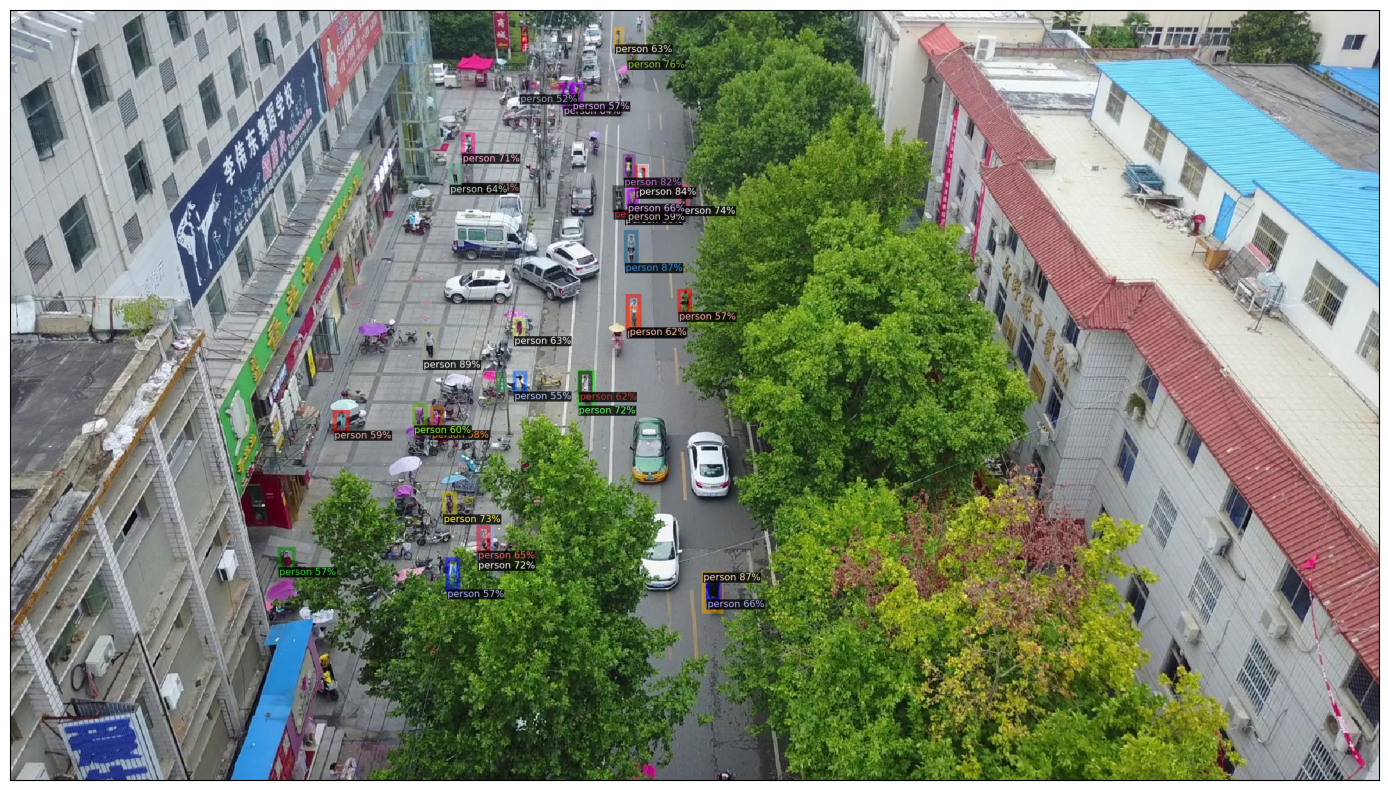

In [53]:
# Загрузим изображение
im = cv2.imread("/home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/0000001_02999_d_0000005_jpg.rf.50147156d1b6441a394d4dde52603c9d.jpg")
# Сделаем предсказание
outputs = predictor(im)
# Визуализируем результат
v = Visualizer(im[:, :, ::-1], 
               MetadataCatalog.get("my_dataset_val"), 
               scale=1.2
              )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.xticks([]),plt.yticks([])
plt.imshow(out.get_image())
plt.show()

### Реализуем вручную вычисление метрики IoU

In [54]:
def compute_iou(box1, box2):
    """
    Вычисляет IoU между двумя bounding box'ами.
    box1 и box2 должны быть в формате [x_min, y_min, x_max, y_max].
    """
    # Определяем координаты пересечения
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Вычисляем площадь пересечения
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Вычисляем площади каждого bounding box'а
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Вычисляем площадь объединения
    union_area = box1_area + box2_area - intersection_area

    # Вычисляем IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

In [55]:
def get_iou_scores(dataset_dicts, predictor):
    iou_scores = []
    for item in dataset_dicts:
        image = cv2.imread(item['file_name'])
        outputs = predictor(image)

        #Предсказанный bbox
        pred_boxes = outputs['instances'].pred_boxes.tensor.cpu().numpy()

        #Размеченный bbox
        gt_boxes = [anno['bbox'] for anno in item['annotations']]

        # Вычисление IoU для каждой пары предсказанного и истинного bbox
        for gt_box in gt_boxes:
            for pred_box in pred_boxes:
                iou_score = compute_iou(gt_box, pred_box)
                iou_scores.append(iou_score)

    return iou_scores

In [56]:
predictor = DefaultPredictor(predictor_cfg)
test_dataset = DatasetCatalog.get('my_dataset_val')

iou_scores = get_iou_scores(test_dataset, predictor)
average_iou = sum(iou_scores) / len(iou_scores)
print(f'Среднее IoU: {average_iou}')

[03/16 15:38:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jupyter/datasphere/project/output/model_final.pth ...
WARNING [03/16 15:38:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/16 15:38:42 d2.data.datasets.coco]: Loaded 545 images in COCO format from /home/jupyter/datasphere/project/Aerial-Person-Detection-3/valid/_annotations_filtered.coco.json
Среднее IoU: 2.9822605072222964e-06


Среднее IoU: 3.6694488999272694e-06

Среднее IoU: 3.6694488999272694e-06